In [ ]:
!pip install datasets
!pip install keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.



# **Painting style classification using CNN**

###**Loading the data**

In [ ]:
from datasets import load_dataset

dataset = load_dataset("keremberke/painting-style-classification", name="full")

label_names = dataset['train'].features['labels'].names
print(label_names)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/4493 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1295 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/629 [00:00<?, ? examples/s]

['Realism', 'Art_Nouveau_Modern', 'Analytical_Cubism', 'Cubism', 'Expressionism', 'Action_painting', 'Synthetic_Cubism', 'Symbolism', 'Ukiyo_e', 'Naive_Art_Primitivism', 'Post_Impressionism', 'Impressionism', 'Fauvism', 'Rococo', 'Minimalism', 'Mannerism_Late_Renaissance', 'Color_Field_Painting', 'High_Renaissance', 'Romanticism', 'Pop_Art', 'Contemporary_Realism', 'Baroque', 'New_Realism', 'Pointillism', 'Northern_Renaissance', 'Early_Renaissance', 'Abstract_Expressionism']


In [ ]:
dataset
# The data is already split into train, validation and test

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 4493
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1295
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 629
    })
})

##**Preprocessing transformations for images**, including resizing, converting to tensors, and normalizing pixel values, and then applies these transformations on-the-fly to the training, testing, and validation dataset, so that its ready to be used in the model


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Function to preprocess a single image
def preprocess_image(image):
    # Resize image to 224*224
    image = tf.image.resize(image, (224, 224))
    # Normalize image pixels to [0, 1]
    image = image / 255.0
    return image

# Preprocess the entire dataset
def preprocess_dataset(dataset):
    images = []
    labels = []

    for example in dataset:
        image = example['image']
        label = example['labels']

        image = preprocess_image(image)
        images.append(image)
        labels.append(label)

    # Convert lists to tensors
    images = tf.stack(images)
    labels = tf.convert_to_tensor(labels)

    return images, labels

# Preprocess the train, validation, and test sets
train_features, train_labels = preprocess_dataset(dataset['train'])
val_features, val_labels = preprocess_dataset(dataset['validation'])
test_features, test_labels = preprocess_dataset(dataset['test'])

###**Plotting some examples**

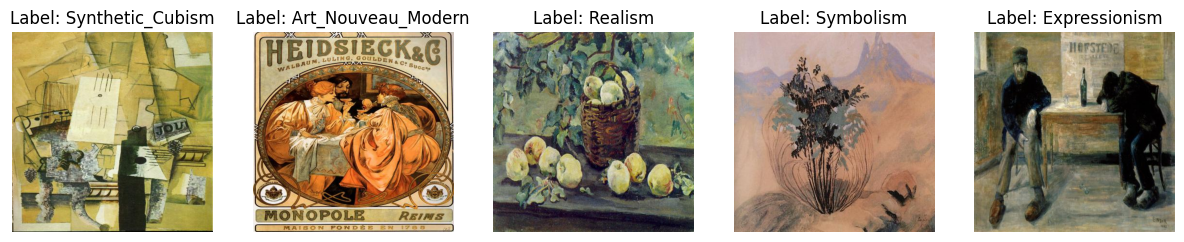

In [ ]:
import matplotlib.pyplot as plt
def show_examples(dataset, num_examples):
    fig, axes = plt.subplots(1, num_examples, figsize=(15, 5))
    for i, example in enumerate(dataset.shuffle(seed=42).select(range(num_examples))):
        image = example['image']
        label = example['labels']
        label_name = label_names[label]
        axes[i].imshow(image)
        axes[i].set_title(f"Label: {label_name}")
        axes[i].axis('off')
    plt.show()

# Show examples from the training dataset
show_examples(dataset['train'],5)

##**CNN MODEL**

###**First architecture**

In [ ]:
import keras
from keras import models
from keras import layers

batch_size = 32


model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(0.1))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.1))

model.add(layers.Dense(27))


model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



history = model.fit(train_features, train_labels, epochs=17,
                    batch_size=batch_size,
                    validation_data=(val_features, val_labels))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/17
141/141 ━━━━━━━━━━━━━━━━━━━━ 25s 112ms/step - accuracy: 0.1588 - loss: 3.0498 - val_accuracy: 0.1467 - val_loss: 2.9134
Epoch 2/17
141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.1817 - loss: 2.8383 - val_accuracy: 0.1683 - val_loss: 2.7990
Epoch 3/17
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.1979 - loss: 2.7300 - val_accuracy: 0.1992 - val_loss: 2.7642
Epoch 4/17
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.2221 - loss: 2.6049 - val_accuracy: 0.2039 - val_loss: 2.7335
Epoch 5/17
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.2637 - loss: 2.4765 - val_accuracy: 0.1954 - val_loss: 2.6823
Epoch 6/17
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.3082 - loss: 2.3147 - val_accuracy: 0.1900 - val_loss: 2.7196
Epoch 7/17
141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.3684 - loss: 2.1027 - val_accuracy: 0.1884 - val_loss: 2.7370
Epoch 8/17
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.4173 - loss: 1.9293 - val_

**Plotting the result**

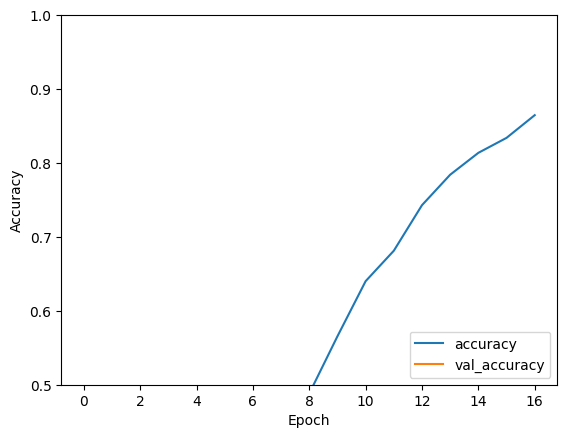

In [ ]:
def plot_learning_curves(history):

    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')

plot_learning_curves(history)

In [ ]:
test_loss, test_acc = model.evaluate(test_features,  test_labels, verbose=2)
print(test_acc)

20/20 - 0s - 20ms/step - accuracy: 0.1860 - loss: 4.2399
0.18600954115390778


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 52, 52, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 173056)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │      11,075,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 27)                  │           1,755 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,401,171 (127.42 MB)

 Trainable params: 11,133,723 (42.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,267,448 (84.94 MB)

###**Second architecture**

In [ ]:
import keras
from keras import models
from keras import layers

batch_size = 32


model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(0.1))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.1))

model.add(layers.Dense(27))


model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



history = model.fit(train_features, train_labels, epochs=17,
                    batch_size=batch_size,
                    validation_data=(val_features, val_labels))

In [ ]:
model.summary()

In [ ]:
plot_learning_curves(history)

In [ ]:
test_loss, test_acc = model.evaluate(test_features,  test_labels, verbose=2)

print(test_acc)

###**Third architecture**

In [ ]:
import keras
from keras import models
from keras import layers

batch_size = 32


model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.1))

model.add(layers.Dense(27))


model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



history = model.fit(train_features, train_labels, epochs=17,
                    batch_size=batch_size,
                    validation_data=(val_features, val_labels))

In [ ]:
model.summary()

In [ ]:
test_loss, test_acc = model.evaluate(test_features,  test_labels, verbose=2)

plot_learning_curves(history)

In [ ]:
print(test_acc)

###**Fourth architecture**

In [ ]:
import keras
from keras import models
from keras import layers

batch_size = 32


model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(27))


model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



history = model.fit(train_features, train_labels, epochs=17,
                    batch_size=batch_size,
                    validation_data=(val_features, val_labels))

In [ ]:
model.summary()

In [ ]:
plot_learning_curves(history)

In [ ]:
test_loss, test_acc = model.evaluate(test_features,  test_labels, verbose=2)
print(test_acc)

##**predict a new image class**

In [ ]:
def predict(image):
  img = preprocess_image(image)

  img = tf.expand_dims(img, axis=0)

  predictions = model.predict(img)

  # Get the class with the highest probability
  predicted_class = label_names[tf.argmax(predictions[0])]

  # Print the predicted class
  print(f'Predicted class: {predicted_class}')

In [ ]:
image = tf.keras.utils.load_img('/content/image.png', target_size=(224, 224))
predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step
Predicted class: Realism
